## H2O-3 Regression Tutorial

[**1B. Introduction to Machine Learning with H2O-3 - Regression**](https://training.h2o.ai/products/1b-introduction-to-machine-learning-with-h2o-3-regression)に沿ったチュートリアル

[**H2O 3 - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/index.html)  
[**Python - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/index.html)

注意：[XGBoost(H2OXGBoostEstimator)はWindows上で動作しない](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/xgboost.html#limitations)

#### 目次
- [Initial Setup](#InitialSetup)
    - パッケージのインポート
    - H2Oクラスターの開始
    - データのロード
- [Start Experiment](#StartExperiment)
    - データの確認
    - 学習(train)/検証(valid)/テスト(test)データセットへの分割
    - 利用変数の定義
- [Build an XGBoost Model](#BuildXGBoostModel)
    - XGBoostモデルの作成(デフォルト設定)と学習
    - 学習の履歴の表示
    - 学習結果の確認
    - train/validデータにおける精度確認
- [Build a Deep Learning Model](#BuildDeepLearningModel)
    - Neural Networkモデルの作成(デフォルト設定)と学習
    - 学習結果の確認
    - train/validデータにおける精度確認
- [Tune the XGBoost Model with H2O GridSearch](#TuneXGBoostModelGridSearch)
    - ハイパーパラメータチューニング（グリッドサーチ・ランダムサーチ）
    - チューニング結果の確認
    - validデータにおけるデフォルト設定とチューニング結果の比較
- [Tune the Deep Learning with H2O GridSearch](#TuneDeepLearningModelGridSearch)
    - ハイパーパラメータチューニング（グリッドサーチ・ランダムサーチ）
    - チューニング結果の確認
    - Ckeckpoint機能
    - validデータにおけるデフォルト設定とチューニング結果の比較
- [Test Set Performance](#TestSetPerformance)
    - testデータにおける、チューニング済み2モデルの結果の比較
    - H2Oクラスターの停止

***

<a id='InitialSetup'></a>
### Initial Setup

In [1]:
#Import H2O and other libraries that will be used in this tutorial 
import h2o
import matplotlib as plt
%matplotlib inline

#Import the Estimators
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators import H2OXGBoostEstimator

#Import h2o grid search 
import h2o.grid 
from h2o.grid.grid_search import H2OGridSearch

In [2]:
#> h2oパッケージのバージョン確認
print(h2o.__version__)

3.30.1.2


In [3]:
#> H2Oクラスターの開始
h2o.init(url='http://localhost:54321')

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_261"; Java(TM) SE Runtime Environment (build 1.8.0_261-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.261-b12, mixed mode)
  Starting server from /home/ec2-user/anaconda3/envs/h2o_3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmprqz4547v
  JVM stdout: /tmp/tmprqz4547v/h2o_ec2_user_started_from_python.out
  JVM stderr: /tmp/tmprqz4547v/h2o_ec2_user_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Tokyo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_ec2_user_fk4186
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.677 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [4]:
#> データのロード
loan_level = h2o.import_file("https://s3.amazonaws.com/data.h2o.ai/DAI-Tutorials/loan_level_500k.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


連邦住宅金融抵当公庫(Freddie Mac)が提供する約20年間(1999/1-2018/12)の住宅ローン(Fixed-Rate Mortgages)の履歴データ。金利をターゲット変数として回帰の説明に使用する。  
  
[Data Reference](http://www.freddiemac.com/research/datasets/sf_loanlevel_dataset.page)  
[変数等データ詳細に関して](http://www.freddiemac.com/fmac-resources/research/pdf/user_guide.pdf)  
  
行数:500,137、列数:27（約80MB）

***

<a id='StartExperiment'></a>
### Start Experiment

In [5]:
loan_level.head()

CREDIT_SCORE,FIRST_PAYMENT_DATE,FIRST_TIME_HOMEBUYER_FLAG,MATURITY_DATE,METROPOLITAN_STATISTICAL_AREA,MORTGAGE_INSURANCE_PERCENTAGE,NUMBER_OF_UNITS,OCCUPANCY_STATUS,ORIGINAL_COMBINED_LOAN_TO_VALUE,ORIGINAL_DEBT_TO_INCOME_RATIO,ORIGINAL_UPB,ORIGINAL_LOAN_TO_VALUE,ORIGINAL_INTEREST_RATE,CHANNEL,PREPAYMENT_PENALTY_MORTGAGE_FLAG,PRODUCT_TYPE,PROPERTY_STATE,PROPERTY_TYPE,POSTAL_CODE,LOAN_SEQUENCE_NUMBER,LOAN_PURPOSE,ORIGINAL_LOAN_TERM,NUMBER_OF_BORROWERS,SELLER_NAME,SERVICER_NAME,PREPAID,DELINQUENT
669,200206,N,202901,nan,0,1,O,80,33,162000,80,7.12,R,N,FRM,WV,SF,26100,F199Q1000004,P,320,2,Other sellers,Other servicers,TRUE,FALSE
732,199904,N,202903,17140,0,1,O,25,10,53000,25,6.5,R,N,FRM,OH,SF,45200,F199Q1000005,N,360,1,Other sellers,Other servicers,TRUE,FALSE
679,200208,N,202902,15940,30,1,O,91,48,133000,91,6.75,R,N,FRM,OH,SF,44700,F199Q1000007,P,319,1,Other sellers,Other servicers,TRUE,FALSE
721,200209,N,202902,38060,0,1,O,39,13,174000,39,6.625,T,N,FRM,AZ,SF,85200,F199Q1000013,N,318,2,Other sellers,Other servicers,TRUE,FALSE
618,200210,N,202902,10420,25,1,O,85,24,122000,85,6.375,R,N,FRM,OH,SF,44200,F199Q1000015,N,317,2,Other sellers,Other servicers,TRUE,FALSE
738,200211,N,202903,10420,0,1,O,73,44,218000,73,6,R,N,FRM,OH,SF,44300,F199Q1000016,P,317,2,Other sellers,Other servicers,TRUE,FALSE
761,200211,N,202904,nan,0,1,O,73,31,138000,73,6.375,R,N,FRM,SC,PU,29500,F199Q1000017,P,318,2,Other sellers,Other servicers,TRUE,FALSE
707,200211,N,202903,33340,0,1,O,60,57,136000,60,6.25,R,N,FRM,WI,SF,53000,F199Q1000018,C,317,2,Other sellers,Other servicers,TRUE,FALSE
760,200211,N,202903,33340,0,1,O,63,30,79000,63,6.125,R,N,FRM,WI,SF,53000,F199Q1000019,N,317,2,Other sellers,Other servicers,TRUE,FALSE
691,200302,N,202901,15940,0,1,O,65,25,130000,65,5.875,R,N,FRM,OH,SF,44700,F199Q1000023,P,312,2,Other sellers,Other servicers,TRUE,FALSE


ターゲット変数として利用する「金利(ORIGINAL_INTEREST_RATE)」の分布の確認

In [6]:
loan_level["ORIGINAL_INTEREST_RATE"].describe()

Rows:500137
Cols:1




,ORIGINAL_INTEREST_RATE
type,real
mins,4.625
mean,7.182686863799322
maxs,11.5
sigma,0.5799408623980744
zeros,0
missing,0
0,7.12
1,6.5
2,6.75


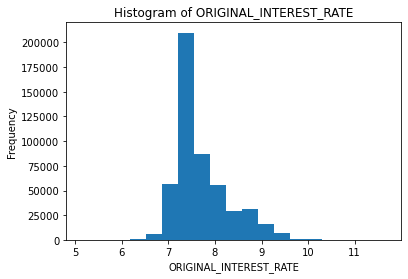

In [7]:
#> ヒストグラムによる分布の確認
loan_level["ORIGINAL_INTEREST_RATE"].hist()

In [8]:
#> 学習/検証/テストデータセットへの分割（学習 : 検証 : テスト = 70% : 15% : 15%）
train, valid, test = loan_level.split_frame([0.7, 0.15], seed=42)
print("＜train/valid/testのデータ数＞")
print( "train:%d valid:%d test:%d" % (train.nrows, valid.nrows, test.nrows ))

＜train/valid/testのデータ数＞
train:350268 valid:74971 test:74898


In [9]:
#> ターゲット変数、特徴量の定義
y = "ORIGINAL_INTEREST_RATE"

ignore = ["ORIGINAL_INTEREST_RATE", 
          "FIRST_PAYMENT_DATE", 
          "MATURITY_DATE", 
          "MORTGAGE_INSURANCE_PERCENTAGE", 
          "PREPAYMENT_PENALTY_MORTGAGE_FLAG", 
          "LOAN_SEQUENCE_NUMBER", 
          "PREPAID", 
          "DELINQUENT", 
          "PRODUCT_TYPE"] 

x = list(set(train.names) - set(ignore))
print(x)

['ORIGINAL_UPB', 'ORIGINAL_LOAN_TERM', 'OCCUPANCY_STATUS', 'ORIGINAL_DEBT_TO_INCOME_RATIO', 'PROPERTY_TYPE', 'NUMBER_OF_BORROWERS', 'PROPERTY_STATE', 'METROPOLITAN_STATISTICAL_AREA', 'SERVICER_NAME', 'CHANNEL', 'POSTAL_CODE', 'ORIGINAL_COMBINED_LOAN_TO_VALUE', 'LOAN_PURPOSE', 'SELLER_NAME', 'CREDIT_SCORE', 'FIRST_TIME_HOMEBUYER_FLAG', 'ORIGINAL_LOAN_TO_VALUE', 'NUMBER_OF_UNITS']


In [10]:
loan_level[x].describe()

Rows:500137
Cols:18




,ORIGINAL_UPB,ORIGINAL_LOAN_TERM,OCCUPANCY_STATUS,ORIGINAL_DEBT_TO_INCOME_RATIO,PROPERTY_TYPE,NUMBER_OF_BORROWERS,PROPERTY_STATE,METROPOLITAN_STATISTICAL_AREA,SERVICER_NAME,CHANNEL,POSTAL_CODE,ORIGINAL_COMBINED_LOAN_TO_VALUE,LOAN_PURPOSE,SELLER_NAME,CREDIT_SCORE,FIRST_TIME_HOMEBUYER_FLAG,ORIGINAL_LOAN_TO_VALUE,NUMBER_OF_UNITS
type,int,int,enum,int,enum,int,enum,int,enum,enum,int,int,enum,enum,int,enum,int,int
mins,8000.0,301.0,,1.0,,1.0,,10180.0,,,600.0,6.0,,,300.0,,6.0,1.0
mean,136493.48478516805,359.8554696013299,,32.91754051870545,,1.6302946648262713,,30777.82473929504,,,55490.8571382869,76.0535707144633,,,712.5362124215468,,75.71071405720141,1.0288902574110184
maxs,578000.0,362.0,,65.0,,2.0,,49740.0,,,99900.0,180.0,,,839.0,,100.0,4.0
sigma,60968.74306564561,1.9082507104186504,,11.111799994455248,,0.48272535304031594,,11333.401144164478,,,29505.38225880303,15.139986048512673,,,54.79126197408813,,14.937717088968643,0.21839057355939082
zeros,0,0,,0,,0,,0,,,0,0,,,0,,0,0
missing,0,0,0,14929,0,247,0,70149,0,0,31,13,0,0,2711,0,9,3
0,162000.0,320.0,O,33.0,SF,2.0,WV,nan,Other servicers,R,26100.0,80.0,P,Other sellers,669.0,N,80.0,1.0
1,53000.0,360.0,O,10.0,SF,1.0,OH,17140.0,Other servicers,R,45200.0,25.0,N,Other sellers,732.0,N,25.0,1.0
2,133000.0,319.0,O,48.0,SF,1.0,OH,15940.0,Other servicers,R,44700.0,91.0,P,Other sellers,679.0,N,91.0,1.0


***

<a id='BuildXGBoostModel'></a>
### Build an XGBoost Model

[**XGBoost - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/xgboost.html#xgboost)  
[**H2OXGBoostEstimator - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2oxgboostestimator)
  
H2O XGBoostはH2Oクラスター上でオリジナルのXGBoost動作させるようビルドされたもの。カテゴリ変数の自動Encodingといった処理も含まれている。

オリジナルのXGBoostの[ドキュメンテーション](https://xgboost.readthedocs.io/en/latest/#)

In [11]:
xgb = H2OXGBoostEstimator(seed=42, 
                          model_id='XGBoost', 
                          nfolds=0, 
                          keep_cross_validation_predictions=False)

%time xgb.train(x=x, y=y, training_frame=train, validation_frame=valid)    # 注：Windowsではサポートされていない

xgboost Model Build progress: |███████████████████████████████████████████| 100%
CPU times: user 322 ms, sys: 21.2 ms, total: 344 ms
Wall time: 27.3 s


- train時にvalidation_frameを指定してホールドアウト法になるので、nfolds=0、keep_cross_validation_predictions=False(それぞれデフォルト)としている

In [12]:
xgb

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost


Model Summary: 


,number_of_trees
,50.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.17744636323081306
RMSE: 0.4212438287154045
MAE: 0.30712844420662655
RMSLE: 0.04987056256391179
Mean Residual Deviance: 0.17744636323081306

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.18013989282125126
RMSE: 0.4244289019626859
MAE: 0.3108204587914598
RMSLE: 0.0503052982338251
Mean Residual Deviance: 0.18013989282125126

Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2020-09-16 07:10:11,0.086 sec,0.0,6.7088631,6.6836794,45.0088439,6.7047501,6.6798046,44.9536733
,2020-09-16 07:10:14,2.386 sec,1.0,4.7104733,4.6786978,22.1885588,4.7073544,4.6757908,22.1591850
,2020-09-16 07:10:14,3.017 sec,2.0,3.3168272,3.2752196,11.0013425,3.3139314,3.2725993,10.9821415
,2020-09-16 07:10:15,3.734 sec,3.0,2.3488131,2.2927392,5.5169229,2.3462673,2.2904798,5.5049702
,2020-09-16 07:10:16,4.329 sec,4.0,1.6810353,1.6051706,2.8258796,1.6786024,1.6031085,2.8177062
,2020-09-16 07:10:16,4.951 sec,5.0,1.2265317,1.1245445,1.5043799,1.2244424,1.1227758,1.4992593
,2020-09-16 07:10:20,9.148 sec,15.0,0.4526525,0.3278245,0.2048943,0.4522328,0.3289853,0.2045145
,2020-09-16 07:10:24,13.172 sec,24.0,0.4384250,0.3211508,0.1922165,0.4389171,0.3229872,0.1926482
,2020-09-16 07:10:29,18.107 sec,35.0,0.4292344,0.3136409,0.1842421,0.4305375,0.3162474,0.1853626
,2020-09-16 07:10:36,24.488 sec,49.0,0.4215230,0.3073758,0.1776816,0.4246206,0.3110081,0.1803027



Variable Importances: 


variable,relative_importance,scaled_importance,percentage
"SELLER_NAME.NORWESTMORTGAGE,INC",25657.9960938,1.0,0.2391252
OCCUPANCY_STATUS.I,7086.1391602,0.2761766,0.0660408
ORIGINAL_UPB,6440.5112305,0.2510138,0.0600237
ORIGINAL_LOAN_TO_VALUE,5813.7905273,0.2265879,0.0541829
LOAN_PURPOSE.P,4025.8632812,0.1569048,0.0375199
---,---,---,---
PROPERTY_STATE.OK,0.8522186,0.0000332,0.0000079
PROPERTY_STATE.ME,0.5269806,0.0000205,0.0000049
PROPERTY_STATE.MT,0.5000267,0.0000195,0.0000047
PROPERTY_STATE.KS,0.0765716,0.0000030,0.0000007


In [13]:
#> 推定したモデルの設定やハイパーパラメータの確認
xgb.actual_params

{'model_id': 'XGBoost',
 'training_frame': 'py_10_sid_a0d0',
 'validation_frame': 'py_11_sid_a0d0',
 'nfolds': 0,
 'keep_cross_validation_models': True,
 'keep_cross_validation_predictions': False,
 'keep_cross_validation_fold_assignment': False,
 'score_each_iteration': False,
 'fold_assignment': None,
 'fold_column': None,
 'response_column': 'ORIGINAL_INTEREST_RATE',
 'ignored_columns': ['PREPAYMENT_PENALTY_MORTGAGE_FLAG',
  'PREPAID',
  'DELINQUENT',
  'PRODUCT_TYPE',
  'MORTGAGE_INSURANCE_PERCENTAGE',
  'LOAN_SEQUENCE_NUMBER',
  'MATURITY_DATE',
  'FIRST_PAYMENT_DATE'],
 'ignore_const_cols': True,
 'offset_column': None,
 'weights_column': None,
 'stopping_rounds': 0,
 'stopping_metric': None,
 'stopping_tolerance': 0.001,
 'max_runtime_secs': 0.0,
 'seed': 42,
 'distribution': 'gaussian',
 'tweedie_power': 1.5,
 'categorical_encoding': 'OneHotInternal',
 'quiet_mode': True,
 'checkpoint': None,
 'export_checkpoints_dir': None,
 'ntrees': 50,
 'max_depth': 6,
 'min_rows': 1.0,
 'm

- 各内容に関しての[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/xgboost.html#defining-an-xgboost-model)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2oxgboostestimator)
- デフォルト設定の確認の場合 `xgb.params`, `xgb.default_params`
- [オリジナルのXGBoostのハイパーパラメーターに関するドキュメント](https://xgboost.readthedocs.io/en/latest/parameter.html#)

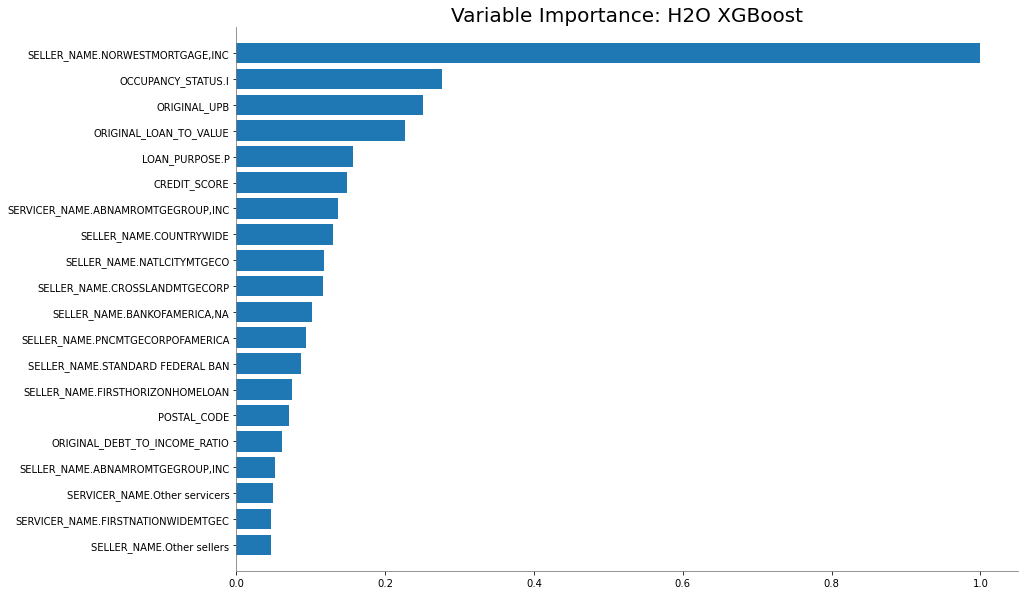

In [14]:
#> 変数重要度の表示
xgb.varimp_plot(20)

- 値自体を取得する場合 `xgb.varimp()`
- H2ORandomForestEstimatorやH2OGradientBoostingEstimatorと異なり、カテゴリ変数はone-hot encodingされた形式で表示

In [15]:
#> validデータに対する予測を実施
xgb_def_pred = xgb.predict(valid)
xgb_def_pred.head(5)

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict
7.20097
6.87724
7.0235
7.25526
7.02648


In [16]:
#> 実測値との比較
xgb_def_pred.cbind(valid['ORIGINAL_INTEREST_RATE'])

predict,ORIGINAL_INTEREST_RATE
7.20097,5.875
6.87724,6.75
7.0235,7.75
7.25526,6.625
7.02648,6.75
7.38137,7
6.8168,7
7.40214,7
7.06643,7.25
7.00728,7


In [17]:
#> validデータでの結果の取得
default_xgb_per = xgb.model_performance(valid)

In [18]:
print('RMSE on train data: ', xgb.rmse())
print('RMSE on valid data: ', default_xgb_per.rmse())

RMSE on train data:  0.4212438287154045
RMSE on valid data:  0.4244289019626859


***

<a id='BuildDeepLearningModel'></a>
### Build a Deep Learning Model

[**Deep Learning (Neural Networks) - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/deep-learning.html)  
[**H2ODeepLearningEstimator - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2odeeplearningestimator)
  
H2O-3では通常のFeedforward Neural Networkのみサポート（CNNやRNNの実装はない）

In [19]:
dl = H2ODeepLearningEstimator(seed=42, 
                              model_id='DL',
                              nfolds= 0, 
                              keep_cross_validation_predictions = False)

%time dl.train(x=x, y=y, training_frame=train, validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 1.51 s, sys: 111 ms, total: 1.62 s
Wall time: 6min 5s


In [20]:
dl

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DL


Status of Neuron Layers: predicting ORIGINAL_INTEREST_RATE, regression, gaussian distribution, Quadratic loss, 73,601 weights/biases, 880.4 KB, 3,504,991 training samples, mini-batch size 1


,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
,1,165,Input,0.0,,,,,,,,,
,2,200,Rectifier,0.0,0.0,0.0,0.0549727,0.2137097,0.0,-0.0194629,0.1941271,-0.1330396,0.2906108
,3,200,Rectifier,0.0,0.0,0.0,0.0498711,0.0523487,0.0,-0.0473627,0.1320981,-0.1935309,0.4387833
,4,1,Linear,,0.0,0.0,0.0013264,0.0009336,0.0,0.0067345,0.0955429,1.3332626,0.0000000




ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.18937988066805572
RMSE: 0.43517798734317403
MAE: 0.31621772696099326
RMSLE: 0.05170373463674052
Mean Residual Deviance: 0.18937988066805572

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 0.1948856473252248
RMSE: 0.4414585454209996
MAE: 0.32199746141537866
RMSLE: 0.05237711273212217
Mean Residual Deviance: 0.1948856473252248

Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_deviance,training_mae,training_r2,validation_rmse,validation_deviance,validation_mae,validation_r2
,2020-09-16 07:10:40,0.000 sec,None,0.0,0,0.0,nan,nan,nan,nan,nan,nan,nan,nan
,2020-09-16 07:10:44,9.502 sec,1706 obs/sec,0.0189369,1,6633.0,0.5473031,0.2995407,0.4111995,0.0882661,0.5486739,0.3010431,0.4111677,0.0983612
,2020-09-16 07:11:37,1 min 2.123 sec,7055 obs/sec,1.0361723,54,362938.0,0.4769127,0.2274458,0.3405789,0.3077067,0.4761632,0.2267313,0.3409403,0.3209284
,2020-09-16 07:12:28,1 min 52.980 sec,8606 obs/sec,2.3951146,125,838932.0,0.4676376,0.2186849,0.3495747,0.3343727,0.4671515,0.2182305,0.3504493,0.3463889
,2020-09-16 07:13:17,2 min 41.599 sec,9552 obs/sec,3.8530440,201,1349598.0,0.4669030,0.2179985,0.3448440,0.3364622,0.4663519,0.2174841,0.3459235,0.3486243
,2020-09-16 07:14:05,3 min 29.910 sec,10100 obs/sec,5.3287426,278,1866488.0,0.4429527,0.1962071,0.3175970,0.4027902,0.4464537,0.1993209,0.3213206,0.4030242
,2020-09-16 07:14:53,4 min 17.928 sec,10545 obs/sec,6.8644152,358,2404385.0,0.4500143,0.2025129,0.3345681,0.3835968,0.4532505,0.2054360,0.3389995,0.3847091
,2020-09-16 07:15:41,5 min 6.348 sec,10852 obs/sec,8.4154219,439,2947653.0,0.4441853,0.1973006,0.3231774,0.3994619,0.4483357,0.2010049,0.3276330,0.3979804
,2020-09-16 07:16:29,5 min 54.379 sec,11089 obs/sec,9.9680787,520,3491499.0,0.4351780,0.1893799,0.3162177,0.4235706,0.4414585,0.1948856,0.3219975,0.4163078
,2020-09-16 07:16:35,6 min 0.314 sec,11093 obs/sec,10.0065978,522,3504991.0,0.4500505,0.2025454,0.3405748,0.3834977,0.4552108,0.2072169,0.3461133,0.3793752



Variable Importances: 


variable,relative_importance,scaled_importance,percentage
"SELLER_NAME.ABNAMROMTGEGROUP,INC",1.0,1.0,0.0125633
SELLER_NAME.WELLSFARGOHOMEMORTGA,0.9975231,0.9975231,0.0125322
"SELLER_NAME.NORWESTMORTGAGE,INC",0.9104674,0.9104674,0.0114385
SELLER_NAME.Other sellers,0.8721871,0.8721871,0.0109576
SELLER_NAME.CROSSLANDMTGECORP,0.8578972,0.8578972,0.0107780
---,---,---,---
PROPERTY_TYPE.missing(NA),0.0,0.0,0.0
CHANNEL.missing(NA),0.0,0.0,0.0
LOAN_PURPOSE.missing(NA),0.0,0.0,0.0
OCCUPANCY_STATUS.missing(NA),0.0,0.0,0.0


In [21]:
#> 推定したモデルの設定やハイパーパラメータの確認
dl.actual_params

{'model_id': 'DL',
 'training_frame': 'py_10_sid_a0d0',
 'validation_frame': 'py_11_sid_a0d0',
 'nfolds': 0,
 'keep_cross_validation_models': True,
 'keep_cross_validation_predictions': False,
 'keep_cross_validation_fold_assignment': False,
 'fold_assignment': None,
 'fold_column': None,
 'response_column': 'ORIGINAL_INTEREST_RATE',
 'ignored_columns': ['PREPAYMENT_PENALTY_MORTGAGE_FLAG',
  'PREPAID',
  'DELINQUENT',
  'PRODUCT_TYPE',
  'MORTGAGE_INSURANCE_PERCENTAGE',
  'LOAN_SEQUENCE_NUMBER',
  'MATURITY_DATE',
  'FIRST_PAYMENT_DATE'],
 'ignore_const_cols': True,
 'score_each_iteration': False,
 'weights_column': None,
 'offset_column': None,
 'balance_classes': False,
 'class_sampling_factors': None,
 'max_after_balance_size': 5.0,
 'max_confusion_matrix_size': 20,
 'max_hit_ratio_k': 0,
 'checkpoint': None,
 'pretrained_autoencoder': None,
 'overwrite_with_best_model': True,
 'use_all_factor_levels': True,
 'standardize': True,
 'activation': 'Rectifier',
 'hidden': [200, 200],
 '

- 各内容に関しての[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/deep-learning.html#defining-a-deep-learning-model)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2odeeplearningestimator)
- デフォルト設定の確認の場合 `dl.params`, `dl.default_params`

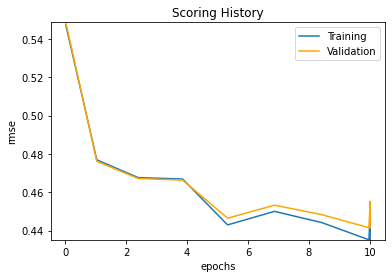

In [22]:
#> 学習の履歴の表示
dl.plot()

In [23]:
print("epochs = ", dl.params['epochs'])

epochs =  {'default': 10.0, 'actual': 10.0, 'input': 10.0}


- デフォルトのエポック数は10

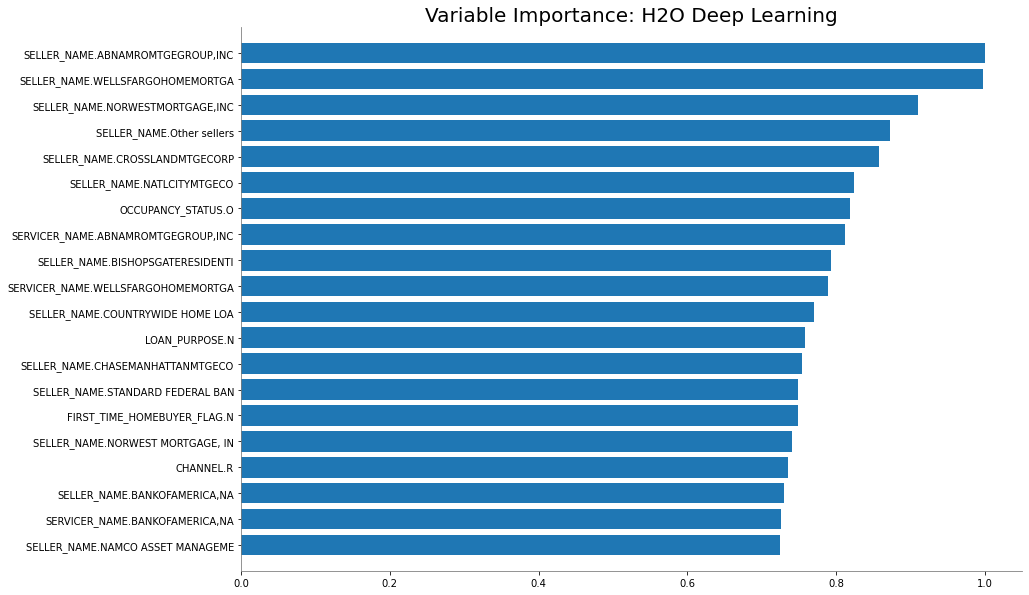

In [24]:
#> 変数重要度の表示
dl.varimp_plot(20)

- 変数重要度は"Gedeon method"により算出（[FAQ](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/deep-learning.html#faq)に記載）

In [25]:
#> validデータでの結果の取得
default_dl_per = dl.model_performance(valid)

In [26]:
print('RMSE on train data: ', dl.rmse())
print('RMSE on valid data: ', default_dl_per.rmse())

RMSE on train data:  0.43517798734317403
RMSE on valid data:  0.4414585454209996


その他NN特有の仕様に関する[FAQ](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/deep-learning.html#faq)

***

<a id='TuneXGBoostModelGridSearch'></a>
### Tune the XGBoost Model with H2O GridSearch

[**Gred Search - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html#grid-hyperparameter-search)  
[**H2OGridSearch - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2ogridsearch)

XGBoostにおいて、max_depthは最も重要なハイパーパラメーターの一つ。デフォルト設定では6。max_depthの値が大きいと学習に時間がかかるので、まずはグリッドサーチでmax_depthを決定した後、その他のハイパーパラメーターにランダムサーチを実施する

In [27]:
xgb = H2OXGBoostEstimator(model_id='xgb', ntrees=100,
                          stopping_rounds=5,  # default
                          stopping_tolerance=1e-4,  # default
                          stopping_metric = "rmse",  # default
                          seed=42)

#hyper_params = {'max_depth' : [5,7,9,10,12,13,15,20]}
hyper_params = {'max_depth' : [5,7,9,10,12,13]}

grid_id = 'depth_grid'

search_criteria = { "strategy":"Cartesian"}

xgb_grid = H2OGridSearch(model=xgb, 
                         hyper_params=hyper_params,
                         grid_id=grid_id,
                         search_criteria=search_criteria)

%time xgb_grid.train(x=x, y=y, training_frame=train, validation_frame = valid)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%
CPU times: user 1.54 s, sys: 77.3 ms, total: 1.62 s
Wall time: 8min 14s


ハイパーパラメータに関して
- max_depth - [ドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/max_depth.html)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.max_depth)

[H2OGridSearchにおいてXGBoostがサポートするハイパーパラメーター一覧](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html#xgboost-hyperparameters)

In [28]:
#> 探索結果の表示（RMSE基準）
xgb_grid.get_grid(sort_by='rmse',decreasing=False)


Hyper-Parameter Search Summary: ordered by increasing rmse


,max_depth,model_ids,rmse
,9,depth_grid_model_3,0.4134846
,10,depth_grid_model_4,0.4137581
,7,depth_grid_model_2,0.4147110
,12,depth_grid_model_5,0.4164160
,13,depth_grid_model_6,0.4203949
,5,depth_grid_model_1,0.4204568


max_depth=9がベストとなった。その設定の下、その他のハイパーパラメーターをランダムサーチしてみる

In [29]:
#> その他のハイパーパラメーターに対しランダムサーチを実施

xgb = H2OXGBoostEstimator(model_id='xgb_grid', max_depth=9, ntrees=100, 
                          stopping_rounds=5,
                          stopping_tolerance=1e-4,
                          stopping_metric = "rmse",
                          seed=42)

hyper_params = {'reg_alpha' : [x*0.01 for x in range(0, 101)],
                'reg_lambda' : [x*0.01 for x in range(0, 101)],
                'learn_rate' : [x*0.01 for x in range(1, 101)],
                'distribution' : ['poisson', 'tweedie', 'gaussian', 'gamma'],
                'booster' : ['gbtree', 'gblinear', 'dart']}

search_criteria_tune = {'strategy': "RandomDiscrete",
                        'max_runtime_secs': 450,   # 探索のストップ基準：最大時間(7分半)
                        'max_models': 50,   # 探索のストップ基準：作成する最大のモデル数
                        'seed' : 42}

xgb_grid = H2OGridSearch(xgb, 
                         hyper_params,
                         grid_id='random_grid',
                         search_criteria=search_criteria_tune)

%time xgb_grid.train(x=x, y=y, training_frame=train, validation_frame=valid)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%
CPU times: user 1.94 s, sys: 74.2 ms, total: 2.01 s
Wall time: 7min 34s


各ハイパーパラメータに関して
- reg_alpha - [APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.reg_alpha)（L1正則化の重み）
- reg_lambda - [APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.reg_lambda)（L2正則化の重み）
- learn_rate - [ドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/learn_rate.html)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.learn_rate)
- distribution - [ドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/distribution.html)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.distribution)
- booster - [APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.booster)

[H2OGridSearchにおいてXGBoostがサポートするハイパーパラメーター一覧](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html#xgboost-hyperparameters)  
[オリジナルのXGBoostのハイパーパラメーターに関するドキュメント](https://xgboost.readthedocs.io/en/latest/parameter.html#)

In [30]:
#> 探索結果の表示（RMSE基準）
xgb_grid.get_grid(sort_by='rmse', decreasing=False)


Hyper-Parameter Search Summary: ordered by increasing rmse


,booster,distribution,learn_rate,reg_alpha,reg_lambda,model_ids,rmse
,dart,gaussian,0.61,0.67,0.34,random_grid_model_3,0.4248153
,gbtree,gaussian,0.6,0.36,0.17,random_grid_model_2,0.4273411
,dart,gaussian,0.89,0.5,0.63,random_grid_model_5,0.4382463
,gbtree,gaussian,0.8200000,0.69,0.88,random_grid_model_1,0.4384176
,gblinear,gaussian,0.08,0.68,0.92,random_grid_model_4,0.6939840


[dart booster](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html)を採用し、rate_dropとskip_dropをランダムサーチを実施し、精度が向上するか確認

In [31]:
xgb = H2OXGBoostEstimator(model_id='xgb', 
                          max_depth=9, 
                          ntrees=100, 
                          distribution='gaussian',
                          reg_alpha= 0.67,
                          reg_lambda= 0.34,
                          learn_rate= 0.61,
                          stopping_rounds=5,  # default
                          stopping_tolerance=1e-4,  # default
                          stopping_metric = "rmse",  # default
                          seed=42,
                          booster = 'dart',
                          normalize_type='forest',
                          one_drop=False,
                          sample_type='uniform')

hyper_params = { 'rate_drop' : [x*0.025 for x in range(0, 21)], #start from 0 to 0.5 in increments of 0.025
                 'skip_drop' : [x*0.025 for x in range(20, 41)] #start from 0.5 to 1 in increments of 0.025
                }

search_criteria_tune = {'strategy': "RandomDiscrete",
                        'max_runtime_secs': 300,  # 5 min  
                        'max_models': 40,   # build no more than 40 models
                        'seed' : 42}

xgb_grid = H2OGridSearch(xgb, hyper_params,
                         grid_id='dart_booster_grid',
                         search_criteria=search_criteria_tune)

%time xgb_grid.train(x=x, y=y, training_frame=train, validation_frame=valid)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%
CPU times: user 1.36 s, sys: 70.6 ms, total: 1.43 s
Wall time: 5min 4s


各ハイパーパラメータに関して
- normalize_type - [APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.normalize_type)（dartのみ）
- one_drop - [APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.one_drop)（dartのみ）
- sample_type - [APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.sample_type)（dartのみ）
- rate_drop - [APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.rate_drop)（dartのみ）
- skip_drop - [APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.xgboost.H2OXGBoostEstimator.skip_drop)（dartのみ）
  
[dart boosterに関するオリジナルのXGBoostのドキュメント](https://xgboost.readthedocs.io/en/latest/parameter.html#additional-parameters-for-dart-booster-booster-dart)

In [32]:
xgb_grid.get_grid(sort_by='rmse',decreasing=False)


Hyper-Parameter Search Summary: ordered by increasing rmse


,rate_drop,skip_drop,model_ids,rmse
,0.275,0.9,dart_booster_grid_model_2,0.4158732
,0.225,0.95,dart_booster_grid_model_1,0.4187967


In [33]:
xgb_grid


Hyper-Parameter Search Summary: ordered by increasing residual_deviance


,rate_drop,skip_drop,model_ids,residual_deviance
,0.275,0.9,dart_booster_grid_model_2,0.1729505
,0.225,0.95,dart_booster_grid_model_1,0.1753907


In [34]:
#> Mean Residual Deviance基準で最適なモデルを取得
best_xgb_model = xgb_grid.models[0] 
best_xgb_model

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  dart_booster_grid_model_2


Model Summary: 


,number_of_trees
,81.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 0.14742585535420155
RMSE: 0.3839607471528848
MAE: 0.27845154195543725
RMSLE: 0.04552358932997624
Mean Residual Deviance: 0.14742585535420155

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 0.17295052026588636
RMSE: 0.41587320214926854
MAE: 0.30242290807971467
RMSLE: 0.0493038032847805
Mean Residual Deviance: 0.17295052026588636

Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
,2020-09-16 07:35:42,3 min 1.899 sec,0.0,6.7088631,6.6836794,45.0088439,6.7047501,6.6798046,44.9536733
,2020-09-16 07:35:43,3 min 3.208 sec,1.0,2.6561735,2.6069449,7.0552576,2.6536824,2.6047770,7.0420302
,2020-09-16 07:35:44,3 min 3.982 sec,2.0,1.1248013,1.0187216,1.2651779,1.1229032,1.0170359,1.2609117
,2020-09-16 07:35:45,3 min 4.812 sec,3.0,0.6125743,0.4525943,0.3752472,0.6115991,0.4514537,0.3740534
,2020-09-16 07:35:46,3 min 5.668 sec,4.0,0.4836919,0.3363244,0.2339579,0.4836126,0.3372060,0.2338811
,2020-09-16 07:35:50,3 min 10.143 sec,10.0,0.4289158,0.3133417,0.1839687,0.4338691,0.3181515,0.1882424
,2020-09-16 07:35:54,3 min 14.301 sec,15.0,0.4206298,0.3065666,0.1769294,0.4278328,0.3128159,0.1830409
,2020-09-16 07:36:00,3 min 20.212 sec,21.0,0.4129572,0.3002513,0.1705336,0.4234790,0.3093437,0.1793345
,2020-09-16 07:36:08,3 min 27.920 sec,28.0,0.4034008,0.2923724,0.1627322,0.4199245,0.3061051,0.1763366
,2020-09-16 07:36:18,3 min 37.888 sec,36.0,0.3986505,0.2887370,0.1589222,0.4185507,0.3048728,0.1751847



Variable Importances: 


variable,relative_importance,scaled_importance,percentage
"SELLER_NAME.NORWESTMORTGAGE,INC",32304.2656250,1.0,0.2331444
OCCUPANCY_STATUS.I,8939.1865234,0.2767185,0.0645154
ORIGINAL_UPB,8297.7207031,0.2568615,0.0598858
ORIGINAL_LOAN_TO_VALUE,7420.7485352,0.2297142,0.0535566
CREDIT_SCORE,6572.1997070,0.2034468,0.0474325
---,---,---,---
PROPERTY_TYPE.CP,4.4970784,0.0001392,0.0000325
PROPERTY_STATE.AK,3.2365997,0.0001002,0.0000234
PROPERTY_STATE.DC,3.1666882,0.0000980,0.0000229
PROPERTY_TYPE.,2.3219380,0.0000719,0.0000168


- RMSE基準で最適なモデルを取得する場合 `xgb_grid.get_grid(sort_by='rmse', decreasing=False).models[0]`

In [35]:
#> validデータに対する結果取得
tuned_xgb_per = best_xgb_model.model_performance(valid)

In [36]:
#> [Build an XGBoost Model]で学習したモデルとランダムサーチした結果をvalidデータで比較
print("Default XGB RMSE: %.4f \nTuned XGB RMSE:%.4f" % (default_xgb_per.rmse(), tuned_xgb_per.rmse()))

Default XGB RMSE: 0.4244 
Tuned XGB RMSE:0.4159


In [37]:
print("Default XGB MAE: %.4f \nTuned XGB MAE:%.4f" % (default_xgb_per.mae(), tuned_xgb_per.mae()))

Default XGB MAE: 0.3108 
Tuned XGB MAE:0.3024


<a id='TuneDeepLearningModelGridSearch'></a>
### Tune the Deep Learning with H2O GridSearch

[**Gred Search - ドキュメント**](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html#grid-hyperparameter-search)  
[**H2OGridSearch - APIドキュメント**](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2ogridsearch)

Neural Networkにおいて、hidden(隠れ層のサイズ)は最も重要なハイパーパラメーターの一つ。まずはグリッドサーチでhiddenを探索してみる   
例えば、300ニューロンを最初の層、200ニューロンを次の層、100ニューロンを最後の隠れ層とする場合、[300,200,100]と指定

In [38]:
dl = H2ODeepLearningEstimator(seed=42, 
                              model_id='DL',
                              nfolds= 0,
                              keep_cross_validation_predictions = False,
                              stopping_metric='RMSE',
                              epochs=10)

hyper_params = {'hidden' : [[165], [330], [495], [100], [200], 
                            [165, 33], [165, 165], [200, 165], [330, 330], 
                            [165, 330, 165]]             
               }

search_criteria_tune = {'strategy': "Cartesian"}

dl_grid = H2OGridSearch(model=dl, 
                        hyper_params=hyper_params,
                        grid_id = 'hidden_layer_grid',
                        search_criteria=search_criteria_tune)

%time dl_grid.train(x=x, y=y, training_frame=train, validation_frame=valid)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
CPU times: user 8.7 s, sys: 183 ms, total: 8.88 s
Wall time: 54min 18s


In [39]:
dl_grid.get_grid(sort_by='rmse', decreasing=False)


Hyper-Parameter Search Summary: ordered by increasing rmse


,hidden,model_ids,rmse
,"[330, 330]",hidden_layer_grid_model_9,0.4266283
,"[165, 330, 165]",hidden_layer_grid_model_10,0.4312506
,[495],hidden_layer_grid_model_3,0.4370657
,"[200, 165]",hidden_layer_grid_model_8,0.4397434
,[330],hidden_layer_grid_model_2,0.4428775
,[200],hidden_layer_grid_model_5,0.4469862
,"[165, 165]",hidden_layer_grid_model_7,0.4473931
,[165],hidden_layer_grid_model_1,0.4492362
,"[165, 33]",hidden_layer_grid_model_6,0.4495317
,[100],hidden_layer_grid_model_4,0.4511593


[activation](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.deeplearning.H2ODeepLearningEstimator.activation)(活性化関数)を"rectifier_with_dropout"として、[hidden_dropout_ratios](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.deeplearning.H2ODeepLearningEstimator.hidden_dropout_ratios)(ドロップアウト)をグリッドサーチしてみる  
（activationが"tanh_with_dropout","rectifier_with_dropout","maxout_with_dropout"の時のみhidden_dropout_ratiosは設定可能）

In [41]:
dl = H2ODeepLearningEstimator(
    epochs=10,
    hidden=[165],     # 上で探索した結果を指定（NNでは再現が困難なため一致しない可能性がある）
    seed=42,
    model_id='DL',
    activation='rectifier_with_dropout')

hyper_params = {'hidden_dropout_ratios' : [[0], [0.01], [0.1], [0.15], [0.25], [0.3], [0.2],
                                           [0.35],[0.5], [0.6], [0.8]]}

search_criteria_tune = {'strategy': "Cartesian"}

dl_grid = H2OGridSearch(model=dl, 
                         hyper_params=hyper_params,
                         grid_id = 'dropout_grid',
                         search_criteria=search_criteria_tune)

%time dl_grid.train(x=x, y=y, training_frame=train, validation_frame=valid)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
CPU times: user 3.47 s, sys: 111 ms, total: 3.58 s
Wall time: 20min 56s


In [42]:
dl_grid.get_grid(sort_by='rmse', decreasing=False)


Hyper-Parameter Search Summary: ordered by increasing rmse


,hidden_dropout_ratios,model_ids,rmse
,[0.6],dropout_grid_model_10,0.4447113
,[0.8],dropout_grid_model_11,0.4454836
,[0.3],dropout_grid_model_6,0.4464202
,[0.35],dropout_grid_model_8,0.4465189
,[0.5],dropout_grid_model_9,0.4477131
,[0.25],dropout_grid_model_5,0.4484906
,[0.15],dropout_grid_model_4,0.4517076
,[0.2],dropout_grid_model_7,0.4597075
,[0.01],dropout_grid_model_2,0.4700554
,[0.1],dropout_grid_model_3,0.4753090


[adaptive_rate](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.deeplearning.H2ODeepLearningEstimator.adaptive_rate)(適応学習率)を無効にし、[rate](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.deeplearning.H2ODeepLearningEstimator.rate)(学習率)をグリッドサーチしてみる

In [43]:
dl = H2ODeepLearningEstimator(
    epochs=10,
    hidden=[165],    # 上で探索した結果を指定（NNでは再現が困難なため一致しない可能性がある）
    seed=42,
    model_id='DL',
    activation = 'rectifier_with_dropout',
    hidden_dropout_ratios=[0.3],     # 上で探索した結果を指定（NNでは再現が困難なため一致しない可能性がある）
    distribution='auto',
    adaptive_rate=False)

hyper_params = { 'rate' : [0.0001, 0.0005, 0.0008, 0.001, 0.0015, 0.0020, 0.003, 0.004, 0.007, 0.009] }

search_criteria_tune = {'strategy': "Cartesian"}

dl_grid = H2OGridSearch(model=dl, 
                        hyper_params=hyper_params,
                        grid_id = 'rate_grid',
                        search_criteria=search_criteria_tune)

%time dl_grid.train(x=x, y=y, training_frame=train, validation_frame=valid)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
Errors/Warnings building gridsearch model

Hyper-parameter: rate, 0.007
failure_details: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation values.
Try a different initial distribution, a bounded activation function (Tanh), adding regularization
(via max_w2, l1, l2, dropout) or learning rate (either enable adaptive_rate or use a smaller learning rate or faster annealing).

For more information visit:
  http://jira.h2o.ai/browse/TN-4'
failure_stack_traces: DistributedException from /127.0.0.1:54321: '

Trying to predict with an unstable model.
Job was aborted due to observed numerical instability (exponential growth).
Either the weights or the bias values are unreasonably large or lead to large activation va


CPU times: user 3.21 s, sys: 42.6 ms, total: 3.25 s
Wall time: 19min 11s


In [44]:
dl_grid.get_grid(sort_by='rmse', decreasing=False)


Hyper-Parameter Search Summary: ordered by increasing rmse


,rate,model_ids,rmse
,0.001,rate_grid_model_4,0.4305794
,0.0015,rate_grid_model_5,0.4306746
,0.002,rate_grid_model_6,0.4309340
,8.0E-4,rate_grid_model_3,0.4317037
,0.003,rate_grid_model_7,0.4321392
,5.0E-4,rate_grid_model_2,0.4329495
,0.004,rate_grid_model_8,0.4370936
,1.0E-4,rate_grid_model_1,0.4460183


上記探索結果のハイパーパラメーターの元、残りいくつかのハイパーパラメーターをランダムサーチし、精度が向上するか確認

In [45]:
dl = H2ODeepLearningEstimator(
     epochs=10,
     hidden=[165],    # 上で探索した結果を指定（NNでは再現が困難なため一致しない可能性がある）
     seed=42,
     model_id='DL',
     activation = 'rectifier_with_dropout',
     hidden_dropout_ratios=[0.3],    # 上で探索した結果を指定（NNでは再現が困難なため一致しない可能性がある）
     distribution='auto',
     adaptive_rate=False,
     l2=1e-5,
     rate=0.0015    # 上で探索した結果を指定（NNでは再現が困難なため一致しない可能性がある）
     )

hyper_params = { 'rate_annealing' : [1e-6, 1e-7, 1e-8, 1e-5],
                 'rate_decay': [1, 0.8, 0.9, 1.1, 1.2],
                 'momentum_ramp' : [10000, 15000, 5000, 20000, 50000, 100000],
                 'momentum_stable' : [0.9, 0.95, 0.99, 0.999],
                 'momentum_start' : [0.9, 0.4, 0.5, 0.7, 0.8]
                }

search_criteria_tune = {'strategy': "RandomDiscrete",
                        'max_runtime_secs': 600, #10 min  
                        'max_models': 100,  # build no more than 100 models
                        'seed' : 42 
                        }

dl_grid = H2OGridSearch(model=dl, 
                        hyper_params=hyper_params,
                        grid_id = 'rate_random_grid',
                        search_criteria=search_criteria_tune,
                        )

%time dl_grid.train(x=x, y=y, training_frame=train, validation_frame=valid)

deeplearning Grid Build progress: |███████████████████████████████████████| 100%
CPU times: user 2.3 s, sys: 91.3 ms, total: 2.39 s
Wall time: 10min


In [46]:
dl_grid.get_grid(sort_by='rmse', decreasing=False)


Hyper-Parameter Search Summary: ordered by increasing rmse


,momentum_ramp,momentum_stable,momentum_start,rate_annealing,rate_decay,model_ids,rmse
,10000.0,0.95,0.5,1.0E-6,0.8,rate_random_grid_model_3,0.4299253
,5000.0,0.999,0.7,1.0E-5,0.9,rate_random_grid_model_2,0.4310985
,10000.0,0.95,0.9,1.0E-5,0.8,rate_random_grid_model_1,0.4327186
,100000.0,0.999,0.9,1.0E-7,0.8,rate_random_grid_model_4,0.4406913


各ハイパーパラメータに関して
- rate_annealing - [ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/rate_annealing.html)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.deeplearning.H2ODeepLearningEstimator.rate_annealing)
- rate_decay - [ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/rate_decay.html)、[APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.deeplearning.H2ODeepLearningEstimator.rate_decay)
- momentum_ramp - [APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.deeplearning.H2ODeepLearningEstimator.momentum_ramp)
- momentum_stable - [APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.deeplearning.H2ODeepLearningEstimator.momentum_stable)
- momentum_start - [APIドキュメント](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2o.estimators.deeplearning.H2ODeepLearningEstimator.momentum_start)
  
[H2OGridSearchにおいてNNがサポートするハイパーパラメーター一覧](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/grid-search.html#deep-learning-hyperparameters)

[Ckeckpoint](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/checkpoint.html#checkpoint)機能を用いると、例えばエポック数などを増やして、学習を再開することができる  
（変更できないハイパーパラメータは、再学習を実施るモデル設定を合わせる必要がある）

In [56]:
best_dl_model = dl_grid.models[0]

dl_checkpoint = H2ODeepLearningEstimator(checkpoint=best_dl_model.model_id,
                                         epochs=200,
                                         hidden=[165],
                                         seed=42,
                                         model_id='DL_checkpoint',
                                         activation = 'rectifier_with_dropout',
                                         hidden_dropout_ratios=[0.3],
                                         distribution='auto',
                                         adaptive_rate=False,
                                         l2=1e-5,
                                         rate=0.0015,
                                         momentum_ramp=10000,
                                         momentum_stable=0.95,
                                         momentum_start=0.5,
                                         rate_annealing=1.0e-6,
                                         rate_decay=0.8,
                                         reproducible=True,
                                         stopping_metric='RMSE',
                                         stopping_tolerance=0.0005,
                                         stopping_rounds=5)

%time dl_checkpoint.train(x=x, y=y, training_frame=train, validation_frame=valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
CPU times: user 2.55 s, sys: 119 ms, total: 2.67 s
Wall time: 12min 12s


In [57]:
#> validデータに対する結果取得
tuned_dl_per = dl_checkpoint.model_performance(valid)
print("Default DL Model RMSE: %.4f \nTuned DL Model RMSE:%.4f" % (default_dl_per.rmse(), tuned_dl_per.rmse()))

Default DL Model RMSE: 0.4415 
Tuned DL Model RMSE:0.4167


In [58]:
print("Default DL Model MAE: %.4f \nTuned DL Model MAE:%.4f" % (default_dl_per.mae(), tuned_dl_per.mae()))

Default DL Model MAE: 0.3220 
Tuned DL Model MAE:0.3034


(参考) [The Definitive Performance Tuning Guide for H2O Deep Learning](https://www.h2o.ai/blog/deep-learning-performance/)

***

<a id='TestSetPerformance'></a>
### Test Set Performance
各チューニング済みのモデルを、testデータで評価

In [59]:
dl_test_per = dl_checkpoint.model_performance(test)
xgb_test_per = best_xgb_model.model_performance(test)

In [60]:
print("XGBoost Test RMSE: %.4f  \nDeep Learning Model Test RMSE: %.4f " % 
      (xgb_test_per.rmse(), dl_test_per.rmse()))

XGBoost Test RMSE: 0.4186  
Deep Learning Model Test RMSE: 0.4195 


In [61]:
print("XGBoost Test MAE: %.4f  \nDeep Learning model Test MAE: %.4f " % 
      (xgb_test_per.mae(), dl_test_per.mae()))

XGBoost Test MAE: 0.3027  
Deep Learning model Test MAE: 0.3043 


In [62]:
xgb_tuned_pred = best_xgb_model.predict(test)  # xgboostによる予測値
test_rate_pred=test['ORIGINAL_INTEREST_RATE'].cbind(xgb_tuned_pred)  # 実測値と結合
dl_tuned_pred = dl_checkpoint.predict(test)  # NNによる予測値
test_rate_pred.cbind(dl_tuned_pred)

xgboost prediction progress: |████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


ORIGINAL_INTEREST_RATE,predict,predict0
6,6.89636,6.64099
6,6.01663,6.32129
7.25,7.0443,7.0197
7.125,7.07205,7.06152
7.125,7.0946,7.15538
7.75,6.87908,7.01356
6.99,6.97976,6.84076
7.125,7.19556,7.18578
7.25,6.99696,7.09463
7.125,6.89005,6.91161


In [63]:
#> H2Oクラスターの終了
h2o.cluster().shutdown()

H2O session _sid_a0d0 closed.
